In [541]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
from pandas import DataFrame
import pickle, random
from tqdm import tqdm
from scipy.spatial import KDTree

In [542]:
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler

In [ ]:
#df0 = pd.read_csv('../spreadsheets/rlhf_1064.csv') # 0.005, 0.75, 0.1, 0.95, 0.999, 12000
#df0 = pd.read_csv('../spreadsheets/rlhf_159nlp.csv') # second Best 0.01, 0.85, 0.01, 0.95, 0.95, 12000
#df0 = pd.read_csv('../spreadsheets/rlhf_small_07rl.csv') # Best
#df0 = pd.read_csv('../spreadsheets/rlhf_large_1072.csv')
#df0 = pd.read_csv('../spreadsheets/shufled_rlhf_11rl.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_small_12rl.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_small_15rl.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_large_154nlp_balanced.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_small_19rl.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_small_24rl.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_small_23rl.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_small_25rl.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_small_26rl.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_small_157nlp.csv') # 0.7, 0.95, 0.5, 0.999, 0.99, 16000
#df0 = pd.read_csv('../spreadsheets/rlhf_small_157nlpgate.csv') # 0.25, 0.95, 0.01, 0.997, 0.999, 14000
#df0 = pd.read_csv('../spreadsheets/rlhf_small_29rl.csv') # 0.9, 0.9, 0.005, 0.95, 0.999, 10000,
#df0 = pd.read_csv('../spreadsheets/rlhf_small_30rl.csv') # 0.005, 0.75, 0.1, 0.95, 0.999, 12000
#df0 = pd.read_csv('../spreadsheets/rlhf_small_32rl.csv') # 0.01, 0.85, 0.01, 0.95, 0.95, 12000
#df0 = pd.read_csv('../spreadsheets/rlhf_small_33rl.csv')# 0.05, 0.85, 0.01, 0.997, 0.95, 4000
# df0 = pd.read_csv('../spreadsheets/rlhf_small_36rl.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_small_39rl.csv')# 0.05, 0.85, 0.01, 0.997, 0.95, 4000
#df0 = pd.read_csv('../spreadsheets/rlhf_small_154nlp_refined.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_large_27rl.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_small_43rl.csv') # 0.001, 0.99, 1.0, 0.95, 0.99, 10000
#df0 = pd.read_csv('../spreadsheets/rlhf_1064_2.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_large_154nlp_refined.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_large_46rl_balanced.csv')
df0 = pd.read_csv('../spreadsheets/rlhf_large_71rl_refined.csv')

In [544]:
df0.columns

Index(['open', 'high', 'ema-26', 'ema-12', 'low', 'mean-grad-hist', 'close',
       'volume', 'sma-05', 'sma-07', 'sma-25', 'long_jcrosk', 'short_kdj',
       'sma-compare', 'ask', 'bid', 'is_short', 'nlpreds', 'action',
       'predicted_action', 'reward', 'refined-action'],
      dtype='object')

In [545]:
#df0['action'] = df0['action'].replace('go_long', 'do_nothing')

In [546]:
df0.head()

,open,high,ema-26,ema-12,low,mean-grad-hist,close,volume,sma-05,sma-07,...,short_kdj,sma-compare,ask,bid,is_short,nlpreds,action,predicted_action,reward,refined-action
0,0.4370,0.4489,0.433521,0.427565,0.4368,0,0.444,3.393058e+06,0.43750,0.437086,...,0,0,1.710009e+06,1.683049e+06,1,go_long,do_nothing,go_short,-17.884543,do_nothing
1,95.7100,98.6400,95.003382,92.862650,95.6800,1,97.240,1.588277e+05,96.62200,96.552857,...,0,0,8.004356e+04,7.878414e+04,1,go_long,go_long,go_short,2.516894,go_long
2,2.9410,2.9460,2.954570,2.978340,2.8000,1,2.848,4.523280e+05,2.93440,2.944429,...,0,1,2.225307e+05,2.297973e+05,1,go_long,go_long,do_nothing,19.229036,go_long
3,3251.1000,3321.7300,3220.306179,3198.109119,3243.2000,0,3302.170,3.151710e+05,3249.67600,3233.615714,...,0,0,1.588136e+05,1.563574e+05,1,go_long,go_long,go_short,4.416351,go_long
4,1.6892,1.7862,1.638430,1.606013,1.6824,0,1.750,1.163686e+07,1.64886,1.636814,...,0,0,5.921292e+06,5.715570e+06,0,go_long,do_nothing,go_long,-0.000283,do_nothing


In [547]:
#df0['nlpreds'].value_counts()

In [548]:
#df0['refined-action'].value_counts()

In [549]:
df0['nlpreds'].value_counts()

nlpreds
do_nothing    235
go_long       194
go_short       58
Name: count, dtype: int64

In [550]:
def prep_data(df: DataFrame) -> DataFrame:
    train_data = pd.DataFrame()
    for col in df.columns:
        col_name = col.split(' ')[0]
        train_data[f'{col_name}'] = df[col]

    return train_data

In [551]:
newdf0 = pd.DataFrame()
train_data = prep_data(df0) if newdf0.empty else prep_data(newdf0)
#train_data = prep_data(newdf0)

In [552]:
train_data.head(2)

,open,high,ema-26,ema-12,low,mean-grad-hist,close,volume,sma-05,sma-07,...,short_kdj,sma-compare,ask,bid,is_short,nlpreds,action,predicted_action,reward,refined-action
0,0.437,0.4489,0.433521,0.427565,0.4368,0,0.444,3393057.500,0.4375,0.437086,...,0,0,1.710009e+06,1.683049e+06,1,go_long,do_nothing,go_short,-17.884543,do_nothing
1,95.710,98.6400,95.003382,92.862650,95.6800,1,97.240,158827.699,96.6220,96.552857,...,0,0,8.004356e+04,7.878414e+04,1,go_long,go_long,go_short,2.516894,go_long


In [ ]:
# Encode actions into numerical values
action_mapping = {"go_long": 0, "go_short": 1, "do_nothing": 2}
action_col = 'action' if newdf0.empty else 'refined-action'
train_data["action_num"] = train_data[f"{action_col}"].map(action_mapping)

In [554]:
train_data.columns

Index(['open', 'high', 'ema-26', 'ema-12', 'low', 'mean-grad-hist', 'close',
       'volume', 'sma-05', 'sma-07', 'sma-25', 'long_jcrosk', 'short_kdj',
       'sma-compare', 'ask', 'bid', 'is_short', 'nlpreds', 'action',
       'predicted_action', 'reward', 'refined-action', 'action_num'],
      dtype='object')

In [555]:
# Define RL parameters
states = train_data[["sma-05", "sma-07", "sma-25", "sma-compare", "is_short"]].values  # Include binary_state
actions = list(action_mapping.values())  # Action space
rewards = train_data["reward"].values  # Rewards
n_states = states.shape[0]
n_actions = len(actions)

In [556]:
# Initialize Q-table
q_table = np.zeros((n_states, n_actions))

In [557]:
list_1 = [
    [0.25, 0.95, 1.0, 0.99, 0.99, 10000],
]

list_2 = [
    [0.25, 0.95, 1.0, 0.99, 0.99, 10000],
]

# Combine the lists and remove duplicates
combined_set = {tuple(sublist) for sublist in list_1 + list_2}

# Convert the set back to a list of lists
combined_list = [list(sublist) for sublist in combined_set]

# Print the combined list
for sublist in combined_list:
    print(sublist)

[0.25, 0.95, 1.0, 0.99, 0.99, 10000]


In [558]:
Hyperparameters = [
    [0.001, 0.99, 1.0, 0.95, 0.99, 10000],
    [1, 0.9, 1.0, 0.99, 0.99, 11000],
    [0.1, 0.9, 0.1, 0.99, 0.995, 4000],
    [0.005, 0.75, 0.1, 0.95, 0.999, 12000],
    [0.001, 0.75, 1.0, 0.99, 0.99, 30000],
    [1, 0.75, 0.005, 0.95, 0.95, 22000],
    [0.01, 0.99, 1.0, 0.95, 0.99, 16000],
    [0.7, 0.99, 1.0, 0.95, 0.997, 8000],
    [0.01, 0.95, 1.0, 0.997, 0.995, 26000],
    [0.25, 0.95, 0.01, 0.997, 0.999, 14000],
    [0.5, 0.85, 0.5, 0.997, 0.997, 14000],
    [0.01, 0.85, 0.01, 0.95, 0.95, 12000],
    [0.9, 0.99, 0.5, 0.995, 0.95, 12000],
    [0.05, 0.9, 0.5, 0.95, 0.999, 4000],
    [0.05, 0.99, 0.5, 0.99, 0.997, 6000],
    [1, 0.75, 0.05, 0.999, 0.999, 10000],
    [0.9, 0.95, 1.0, 0.99, 0.99, 8000],
    [0.25, 0.75, 0.01, 0.995, 0.999, 20000],
    [0.3, 0.75, 1.0, 0.995, 0.99, 10000],
    [1, 0.9, 1.0, 0.999, 0.999, 10000],
    [0.7, 0.75, 1.0, 0.97, 0.999, 28000],
    [0.05, 0.95, 1.0, 0.999, 0.995, 12000],
    [0.7, 0.95, 0.5, 0.999, 0.99, 16000],
    [0.25, 0.95, 1.0, 0.99, 0.99, 10000],
    [0.25, 0.99, 0.01, 0.997, 0.99, 8000],
    [1, 0.95, 0.1, 0.96, 0.96, 12000],
    [0.9, 0.9, 0.005, 0.95, 0.999, 10000],
    [0.05, 0.85, 0.01, 0.997, 0.95, 4000],
    [0.01, 0.9, 0.5, 0.999, 0.999, 1500],
    [1, 0.85, 1.0, 0.95, 0.997, 21000],
    [0.7, 0.9, 0.05, 0.95, 0.95, 20000]



]

In [559]:
for i in enumerate(Hyperparameters):
    print(i)

(0, [0.001, 0.99, 1.0, 0.95, 0.99, 10000])
(1, [1, 0.9, 1.0, 0.99, 0.99, 11000])
(2, [0.1, 0.9, 0.1, 0.99, 0.995, 4000])
(3, [0.005, 0.75, 0.1, 0.95, 0.999, 12000])
(4, [0.001, 0.75, 1.0, 0.99, 0.99, 30000])
(5, [1, 0.75, 0.005, 0.95, 0.95, 22000])
(6, [0.01, 0.99, 1.0, 0.95, 0.99, 16000])
(7, [0.7, 0.99, 1.0, 0.95, 0.997, 8000])
(8, [0.01, 0.95, 1.0, 0.997, 0.995, 26000])
(9, [0.25, 0.95, 0.01, 0.997, 0.999, 14000])
(10, [0.5, 0.85, 0.5, 0.997, 0.997, 14000])
(11, [0.01, 0.85, 0.01, 0.95, 0.95, 12000])
(12, [0.9, 0.99, 0.5, 0.995, 0.95, 12000])
(13, [0.05, 0.9, 0.5, 0.95, 0.999, 4000])
(14, [0.05, 0.99, 0.5, 0.99, 0.997, 6000])
(15, [1, 0.75, 0.05, 0.999, 0.999, 10000])
(16, [0.9, 0.95, 1.0, 0.99, 0.99, 8000])
(17, [0.25, 0.75, 0.01, 0.995, 0.999, 20000])
(18, [0.3, 0.75, 1.0, 0.995, 0.99, 10000])
(19, [1, 0.9, 1.0, 0.999, 0.999, 10000])
(20, [0.7, 0.75, 1.0, 0.97, 0.999, 28000])
(21, [0.05, 0.95, 1.0, 0.999, 0.995, 12000])
(22, [0.7, 0.95, 0.5, 0.999, 0.99, 16000])
(23, [0.25, 0.95, 

In [560]:
#0.3, 0.75, 1.0, 0.995, 0.99, 10000
'''
alpha = 0.7
gamma = 0.75
epsilon = 1.0
min_epsilon = 0.97
decay_rate = 0.97
n_episodes = 28000
n_states = states.shape[0]  # Number of states
n_actions = len(actions)  # Number of actions
'''
alpha, gamma, epsilon, min_epsilon, decay_rate, n_episodes = Hyperparameters[4] # Hyperparameters[30] # Hyperparameters[22] #Hyperparameters[9] # Hyperparameters[21]


In [561]:
def create_state_index_mapping(df):
    state_to_index = {}
    for idx, row in df.iterrows():
        state = (row['sma-05'], row['sma-07'], row['sma-25'], row['sma-compare'], row['is_short'])
        state_to_index[state] = idx
    return state_to_index

# Assuming 'df' is your dataframe used during training
state_to_index = create_state_index_mapping(train_data)

# Save the state_to_index dictionary for later use
np.save('small_state_to_index.npy', state_to_index)


In [562]:

# Helper function to choose an action using epsilon-greedy
def choose_action(state, epsilon):
    if np.random.uniform(0, 1) < epsilon:
        return np.random.randint(0, n_actions)  # Explore: random action
    else:
        return np.argmax(q_table[state])  # Exploit: best known action


In [563]:
# Simplified environment function
def environment_step(current_state, action):
    """
    Simulates the environment's response to an action.
    
    Args:
        current_state (int): The current state of the environment.
        action (int): The action taken by the agent.
    
    Returns:
        next_state (int): The next state after taking the action.
        reward (float): The reward received after taking the action.
    """
    # Define the environment logic here
    next_state = current_state + 1  # Example: Move to the next state
    reward = rewards[next_state]    # Example: Reward is based on the next state
    
    return next_state, reward

# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)

# Initialize a list to store rewards per episode
rewards_per_episode = []

# Training loop
for episode in tqdm(range(n_episodes), desc="evaluating results per episode ..."):
    current_state = np.random.randint(0, n_states)  # Random initial state
    total_reward = 0  # Initialize total reward for the current episode

    while current_state < n_states - 1:
        action = choose_action(current_state, epsilon)
        
        # Use the environment function to get the next state and reward
        next_state, reward = environment_step(current_state, action)

        best_next_action = np.argmax(q_table[next_state])
        q_table[current_state, action] += alpha * (
            reward + gamma * q_table[next_state, best_next_action] - q_table[current_state, action]
        )
        
        total_reward += reward  # Accumulate reward for the current episode
        current_state = next_state  # Move to next state

    rewards_per_episode.append(total_reward)  # Store the total reward for the current episode

    # Decay epsilon
    epsilon = max(min_epsilon, epsilon * decay_rate)

    # Optional: Log progress
    if episode % 800 == 0:  # Adjust logging frequency as needed
        print(f"Episode {episode}/{n_episodes} - Total Reward: {total_reward}, Epsilon: {epsilon}")

# Example: Save the Q-table
np.save("small_q_table.npy", q_table)

evaluating results per episode ...:   0%|          | 62/30000 [00:00<00:48, 618.78it/s]

Episode 0/30000 - Total Reward: -1816.118925330002, Epsilon: 0.99


evaluating results per episode ...:   3%|▎         | 898/30000 [00:01<00:43, 665.59it/s]

Episode 800/30000 - Total Reward: -1190.499934240003, Epsilon: 0.99


evaluating results per episode ...:   6%|▌         | 1714/30000 [00:02<00:41, 683.99it/s]

Episode 1600/30000 - Total Reward: -1605.6476926900002, Epsilon: 0.99


evaluating results per episode ...:   8%|▊         | 2487/30000 [00:03<00:40, 684.89it/s]

Episode 2400/30000 - Total Reward: -2324.041898079998, Epsilon: 0.99


evaluating results per episode ...:  11%|█         | 3341/30000 [00:04<00:35, 741.96it/s]

Episode 3200/30000 - Total Reward: -4100.7501562100015, Epsilon: 0.99


evaluating results per episode ...:  14%|█▎        | 4122/30000 [00:06<00:37, 689.27it/s]

Episode 4000/30000 - Total Reward: -5184.274198959999, Epsilon: 0.99


evaluating results per episode ...:  16%|█▋        | 4885/30000 [00:07<00:38, 652.46it/s]

Episode 4800/30000 - Total Reward: -3121.657200529999, Epsilon: 0.99


evaluating results per episode ...:  19%|█▉        | 5668/30000 [00:08<00:34, 697.24it/s]

Episode 5600/30000 - Total Reward: -656.21329215, Epsilon: 0.99


evaluating results per episode ...:  22%|██▏       | 6493/30000 [00:09<00:33, 692.71it/s]

Episode 6400/30000 - Total Reward: -1868.70538526, Epsilon: 0.99


evaluating results per episode ...:  24%|██▍       | 7278/30000 [00:10<00:33, 682.15it/s]

Episode 7200/30000 - Total Reward: -3433.25961475, Epsilon: 0.99


evaluating results per episode ...:  27%|██▋       | 8126/30000 [00:12<00:33, 660.04it/s]

Episode 8000/30000 - Total Reward: -2661.299994369998, Epsilon: 0.99


evaluating results per episode ...:  30%|██▉       | 8899/30000 [00:13<00:31, 678.75it/s]

Episode 8800/30000 - Total Reward: -2226.449752389999, Epsilon: 0.99


evaluating results per episode ...:  32%|███▏      | 9727/30000 [00:14<00:30, 661.71it/s]

Episode 9600/30000 - Total Reward: -2588.6728600099977, Epsilon: 0.99


evaluating results per episode ...:  35%|███▌      | 10515/30000 [00:15<00:28, 691.46it/s]

Episode 10400/30000 - Total Reward: -3046.321511929999, Epsilon: 0.99


evaluating results per episode ...:  38%|███▊      | 11339/30000 [00:16<00:25, 734.51it/s]

Episode 11200/30000 - Total Reward: -3527.614069460001, Epsilon: 0.99


evaluating results per episode ...:  40%|████      | 12092/30000 [00:17<00:26, 677.44it/s]

Episode 12000/30000 - Total Reward: -4504.39394988, Epsilon: 0.99


evaluating results per episode ...:  43%|████▎     | 12929/30000 [00:19<00:25, 680.55it/s]

Episode 12800/30000 - Total Reward: -3413.6268529299996, Epsilon: 0.99


evaluating results per episode ...:  46%|████▌     | 13713/30000 [00:20<00:22, 726.07it/s]

Episode 13600/30000 - Total Reward: -5136.572212499999, Epsilon: 0.99


evaluating results per episode ...:  48%|████▊     | 14524/30000 [00:21<00:21, 703.60it/s]

Episode 14400/30000 - Total Reward: -3294.4567535799993, Epsilon: 0.99


evaluating results per episode ...:  51%|█████     | 15290/30000 [00:22<00:23, 616.79it/s]

Episode 15200/30000 - Total Reward: -1137.931653800001, Epsilon: 0.99


evaluating results per episode ...:  54%|█████▎    | 16104/30000 [00:23<00:20, 687.20it/s]

Episode 16000/30000 - Total Reward: 179.96170312000103, Epsilon: 0.99


evaluating results per episode ...:  56%|█████▋    | 16877/30000 [00:24<00:18, 700.76it/s]

Episode 16800/30000 - Total Reward: -1702.7233792600002, Epsilon: 0.99


evaluating results per episode ...:  59%|█████▉    | 17702/30000 [00:26<00:18, 653.89it/s]

Episode 17600/30000 - Total Reward: -2805.2560532499974, Epsilon: 0.99


evaluating results per episode ...:  62%|██████▏   | 18490/30000 [00:27<00:16, 709.88it/s]

Episode 18400/30000 - Total Reward: -1751.3771162500004, Epsilon: 0.99


evaluating results per episode ...:  64%|██████▍   | 19320/30000 [00:28<00:18, 579.61it/s]

Episode 19200/30000 - Total Reward: -4311.975542989999, Epsilon: 0.99


evaluating results per episode ...:  67%|██████▋   | 20080/30000 [00:29<00:14, 694.13it/s]

Episode 20000/30000 - Total Reward: -504.85151041999995, Epsilon: 0.99


evaluating results per episode ...:  70%|██████▉   | 20928/30000 [00:31<00:13, 661.72it/s]

Episode 20800/30000 - Total Reward: -3551.0492038500006, Epsilon: 0.99


evaluating results per episode ...:  72%|███████▏  | 21731/30000 [00:32<00:12, 677.19it/s]

Episode 21600/30000 - Total Reward: -4972.998737429999, Epsilon: 0.99


evaluating results per episode ...:  75%|███████▌  | 22573/30000 [00:33<00:11, 652.73it/s]

Episode 22400/30000 - Total Reward: -2550.979501119998, Epsilon: 0.99


evaluating results per episode ...:  78%|███████▊  | 23292/30000 [00:34<00:10, 619.80it/s]

Episode 23200/30000 - Total Reward: -197.40362294999963, Epsilon: 0.99


evaluating results per episode ...:  81%|████████  | 24163/30000 [00:36<00:09, 586.86it/s]

Episode 24000/30000 - Total Reward: -4638.518100509999, Epsilon: 0.99


evaluating results per episode ...:  83%|████████▎ | 24877/30000 [00:37<00:08, 615.30it/s]

Episode 24800/30000 - Total Reward: -1285.6717980900023, Epsilon: 0.99


evaluating results per episode ...:  86%|████████▌ | 25728/30000 [00:38<00:06, 651.52it/s]

Episode 25600/30000 - Total Reward: -1532.938294220002, Epsilon: 0.99


evaluating results per episode ...:  88%|████████▊ | 26481/30000 [00:39<00:05, 660.17it/s]

Episode 26400/30000 - Total Reward: -4638.518100509999, Epsilon: 0.99


evaluating results per episode ...:  91%|█████████ | 27341/30000 [00:40<00:03, 680.20it/s]

Episode 27200/30000 - Total Reward: -1162.2516025900006, Epsilon: 0.99


evaluating results per episode ...:  94%|█████████▎| 28065/30000 [00:41<00:02, 671.62it/s]

Episode 28000/30000 - Total Reward: -2500.1739277699985, Epsilon: 0.99


evaluating results per episode ...:  96%|█████████▋| 28912/30000 [00:43<00:01, 658.36it/s]

Episode 28800/30000 - Total Reward: 132.27198298000192, Epsilon: 0.99


evaluating results per episode ...:  99%|█████████▉| 29759/30000 [00:44<00:00, 605.27it/s]

Episode 29600/30000 - Total Reward: 209.02523003000132, Epsilon: 0.99


evaluating results per episode ...: 100%|██████████| 30000/30000 [00:44<00:00, 668.01it/s]


In [564]:
def load_q_table(file_path):
    return np.load(file_path)

def load_state_index_mapping(file_path):
    return np.load(file_path, allow_pickle=True).item()

loaded_mapping = load_state_index_mapping(file_path="small_state_to_index.npy")
loaded_qtable = load_q_table(file_path="small_q_table.npy")

In [565]:
def prep_state(sma_05: float, sma_07: float, sma_25: float, sma_compare: int, is_short: int):
    state = np.array([[sma_05, sma_07, sma_25, sma_compare, is_short]])
    if not np.all(np.isfinite(state)):
        state = np.nan_to_num(state, nan=0.0, posinf=0.0, neginf=0.0)
    return state



In [566]:

def predict_action(state, q_table, state_to_index, action_mapping, default_action: str = None):
    state_tuple = tuple(state.flatten())

    state_index = state_to_index.get(state_tuple, -1)

    if not state_index == -1:
        try:
            q_values = q_table[state_index]
        except ValueError as e:
            print(e)
            #return default_action
    else:
        state_tuples = list(state_to_index.keys())
        kdtree = KDTree(state_tuples)
        distance, index = kdtree.query(state.flatten())
        nearest_state_tuple = state_tuples[index]
        new_state_index = state_to_index[nearest_state_tuple]
        q_values = loaded_qtable[new_state_index]
    
    #q_values = q_table[state_index]
    best_action_index = np.argmax(q_values)
    action = [action for action, index in action_mapping.items() if index == best_action_index][0]
    return action


In [567]:
# Example usage:
with open("small_q_table.npy", "rb") as f:
    q_table = load_q_table("small_q_table.npy")

with open("small_state_to_index.npy", "rb") as f:
    state_to_index = load_state_index_mapping("small_state_to_index.npy")

In [568]:
X = train_data[["sma-05", "sma-07", "sma-25", "sma-compare", "is_short"]].values
state_1 = list(X[-1:].flatten()) # sample: [[0.87024    0.85277143 0.779504   0.         1.        ]]

state = prep_state(*state_1)
action_mapping = {"go_long": 0, "go_short": 1, "do_nothing": 2}


In [569]:
try:
    predicted_action = predict_action(state, q_table, state_to_index, action_mapping)
    print(f"The predicted action for the state is: {predicted_action}")
except ValueError as e:
    print(e)
    print("The state is not found in the state index mapping.")

The predicted action for the state is: go_long


In [570]:
# Predict an entire range
for idx, row in train_data.iterrows():
    state = row[["sma-05", "sma-07", "sma-25", "sma-compare", "is_short"]].values
    action = predict_action(state, q_table, state_to_index, action_mapping)
    train_data.loc[idx, "predicted_action"] = action

In [571]:
if (train_data['predicted_action'].nunique() < 2):
    raise ValueError("Model predictions are invalid")

In [572]:
train_data['predicted_action'].value_counts()

predicted_action
do_nothing    176
go_long       161
go_short      150
Name: count, dtype: int64

In [573]:
m = train_data[(train_data['nlpreds'] == 'go_long') & (train_data['reward'] > 0)]

In [574]:
m['is_short'].value_counts()

is_short
1    113
0     75
Name: count, dtype: int64

In [575]:
s = df0[(df0['reward'] > 0)]
s['nlpreds'].value_counts()

nlpreds
go_long       188
go_short       56
do_nothing      6
Name: count, dtype: int64

In [576]:
# Performance measures
# Initialize cumulative rewards
cumulative_predicted_reward = 0
cumulative_actual_reward = 0

# Iterate through states to calculate rewards
for state_index in range(n_states - 1):
    # Predicted action from Q-table
    predicted_action = np.argmax(q_table[state_index])  # Best action for the current state
    # Actual action from the ground truth
    actual_action = train_data["action_num"].iloc[state_index]

    # Get reward for predicted action only if it matches the actual action
    if predicted_action == actual_action:
        predicted_reward = rewards[state_index + 1]  # Reward for the correct prediction
        cumulative_predicted_reward += predicted_reward

    # Get actual reward for the ground truth action
    actual_reward = rewards[state_index + 1]
    cumulative_actual_reward += actual_reward

    # Optional: Log progress
    if state_index % 100 == 0:  # Adjust logging frequency as needed
        print(f"Processed state {state_index}/{n_states - 1}")
        print(f"Current Predicted Reward: {cumulative_predicted_reward}")
        print(f"Current Actual Reward: {cumulative_actual_reward}")

# Print results
print(f"Cumulative Predicted Reward: {cumulative_predicted_reward}")
print(f"Cumulative Actual Reward: {cumulative_actual_reward}")

# Optionally calculate efficiency
efficiency = (
    ((cumulative_predicted_reward - cumulative_actual_reward) / abs(cumulative_actual_reward)) * 100
    if cumulative_actual_reward != 0
    else 0
)

print(f"Prediction Efficiency: {efficiency:.2f}%")



Processed state 0/486
Current Predicted Reward: 0
Current Actual Reward: 2.51689387
Processed state 100/486
Current Predicted Reward: 710.10646613
Current Actual Reward: 2004.70264424
Processed state 200/486
Current Predicted Reward: 1607.7180059999994
Current Actual Reward: 4357.68791454
Processed state 300/486
Current Predicted Reward: 1424.5412338599992
Current Actual Reward: 4144.7320186000015
Processed state 400/486
Current Predicted Reward: 305.224771359999
Current Actual Reward: 1750.4896360500013
Cumulative Predicted Reward: -273.8382271400009
Cumulative Actual Reward: 211.5421239000021
Prediction Efficiency: -229.45%


In [577]:
# Accuracy
correct_predictions = 0
for state_index in range(n_states):
    predicted_action = np.argmax(q_table[state_index])  # Predicted action
    actual_action = train_data["action_num"].iloc[state_index]  # Actual action
    if predicted_action == actual_action:
        correct_predictions += 1

accuracy = correct_predictions / n_states
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 38.81%


In [578]:
# Confusion matrix
y_true = train_data["action_num"]  # Actual actions
y_pred = [np.argmax(q_table[state_index]) for state_index in range(n_states)]  # Predicted actions

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[ 62  60  54]
 [ 29  25  20]
 [ 70  65 102]]


In [601]:
def action_reward(action: str, is_short: int):
    m = train_data[(train_data['predicted_action'] == f'{action}') & (train_data['is_short'] == is_short)]
    counts = m['is_short'].value_counts()
    total_reward = m['reward'].cumsum()[-1:].values[0]
    wins = len(m[m['reward'] > 0])
    losses = len(m[m['reward'] <= 0])
    return {
        'counts': counts.get(is_short),
        'total reward': total_reward,
        'winrate': f'{wins * 100 / (losses + wins):.2f}%',
        'per trade profit': m[m['reward'] > 0]['reward'].sum() / wins,
        'per trade loss': m[m['reward'] <= 0]['reward'].sum() / losses
    }

In [602]:
action_reward('do_nothing', 1)

{'counts': 84,
 'total reward': -35.95439132999959,
 'winrate': '50.00%',
 'per trade profit': 21.60254193690476,
 'per trade loss': -22.458598873333333}

In [603]:
dirs = [0,1]
for action in action_mapping.keys():
    for is_short in dirs:
        try:
            print(f'{action} {is_short}: {action_reward(action, is_short)}')
        except IndexError as e:
            print(e)


go_long 0: {'counts': 72, 'total reward': -27.2480144999999, 'winrate': '48.61%', 'per trade profit': 22.286798442, 'per trade loss': -21.81853945864865}
go_long 1: {'counts': 89, 'total reward': 554.6568654999996, 'winrate': '62.92%', 'per trade profit': 22.932608558392854, 'per trade loss': -22.108157993030307}
go_short 0: {'counts': 75, 'total reward': -27.076897609999815, 'winrate': '50.67%', 'per trade profit': 21.21856205026316, 'per trade loss': -22.523844743783783}
go_short 1: {'counts': 75, 'total reward': 384.95088403000017, 'winrate': '62.67%', 'per trade profit': 21.466384040000005, 'per trade loss': -22.284613066071426}
do_nothing 0: {'counts': 92, 'total reward': -655.67086535, 'winrate': '34.78%', 'per trade profit': 21.966035208125, 'per trade loss': -22.6430665335}
do_nothing 1: {'counts': 84, 'total reward': -35.95439132999959, 'winrate': '50.00%', 'per trade profit': 21.60254193690476, 'per trade loss': -22.458598873333333}


In [582]:
print(train_data['predicted_action'].value_counts())

predicted_action
do_nothing    176
go_long       161
go_short      150
Name: count, dtype: int64


### Model correction

In [583]:
# create corrected action
'''
def correct_action(row):
    if row['predicted_action'] == 'go_long' and row['is_short'] == 1 and row['reward'] > 0:
        return 'go_short'
    if row['predicted_action'] == 'go_short' and row['is_short'] == 0 and row['reward'] > 0:
        return 'go_long'
    if row['predicted_action'] == 'do_nothing' and row['is_short'] == 1 and row['reward'] > 0:
        return 'go_short'
    if row['predicted_action'] == 'do_nothing' and row['is_short'] == 0 and row['reward'] > 0:
        return 'go_long'
    return row['action']

def refiner_action(version: str, data: DataFrame = None) -> DataFrame:
    data['refined-action'] = data.apply(lambda x: correct_action(x), axis=1)
    # Validation: Ensure we're fixing the 751 misclassified entries
    misclassified = data[
        (data['predicted_action'] == 'go_long') & 
        (data['refined-action'] == 'go_short')
    ]
    # Add this after applying refined-action
    
    confusion_matrix = pd.crosstab(
        data['refined-action'], 
        data['predicted_action'],  # Assuming you have ground truth column
        rownames=['refined'],
        colnames=['predicted']
    )

    print("Updated Confusion Matrix:")
    print(confusion_matrix) 
    print(f"Corrected {len(misclassified)} go_long->go_short misclassifications")
    
    filename = f'../spreadsheets/rlhf_large_{version}_refined.csv'
    data.to_csv(filename, index=False)
    return data
    '''

'\ndef correct_action(row):\n    if row[\'predicted_action\'] == \'go_long\' and row[\'is_short\'] == 1 and row[\'reward\'] > 0:\n        return \'go_short\'\n    if row[\'predicted_action\'] == \'go_short\' and row[\'is_short\'] == 0 and row[\'reward\'] > 0:\n        return \'go_long\'\n    if row[\'predicted_action\'] == \'do_nothing\' and row[\'is_short\'] == 1 and row[\'reward\'] > 0:\n        return \'go_short\'\n    if row[\'predicted_action\'] == \'do_nothing\' and row[\'is_short\'] == 0 and row[\'reward\'] > 0:\n        return \'go_long\'\n    return row[\'action\']\n\ndef refiner_action(version: str, data: DataFrame = None) -> DataFrame:\n    data[\'refined-action\'] = data.apply(lambda x: correct_action(x), axis=1)\n    # Validation: Ensure we\'re fixing the 751 misclassified entries\n    misclassified = data[\n        (data[\'predicted_action\'] == \'go_long\') & \n        (data[\'refined-action\'] == \'go_short\')\n    ]\n    # Add this after applying refined-action\n    \n

In [584]:
def correct_action(row):
    if row['predicted_action'] == 'go_long' and row['is_short'] == 1 and row['reward'] > 0:
        row['is_short'] = 0  # Change to long position
        return 'go_short'
    if row['predicted_action'] == 'go_short' and row['is_short'] == 0 and row['reward'] > 0:
        row['is_short'] = 1  # Change to short position
        return 'go_long'
    if row['predicted_action'] == 'do_nothing' and row['is_short'] == 1 and row['reward'] > 0:
        row['is_short'] = 0  # Change to long position
        return 'go_short'
    if row['predicted_action'] == 'do_nothing' and row['is_short'] == 0 and row['reward'] > 0:
        row['is_short'] = 1  # Change to short position
        return 'go_long'
    return row['action']

def refiner_action(version: str, data: pd.DataFrame) -> pd.DataFrame:
    data[['refined-action', 'is_short']] = data.apply(lambda x: pd.Series([correct_action(x), x['is_short']]), axis=1)

    # Validation: Check if is_short aligns with refined-action
    inconsistency = data[
        ((data['refined-action'] == 'go_short') & (data['is_short'] == 0)) |
        ((data['refined-action'] == 'go_long') & (data['is_short'] == 1))
    ]
    
    print(f"Number of inconsistent rows: {len(inconsistency)}")
    
    # Updated Confusion Matrix
    confusion_matrix = pd.crosstab(
        data['refined-action'], 
        data['predicted_action'],
        rownames=['refined'],
        colnames=['predicted']
    )

    print("Updated Confusion Matrix:")
    print(confusion_matrix)
    
    filename = f'../spreadsheets/rlhf_large_{version}_refined.csv'
    data.to_csv(filename, index=False)
    
    return data


In [585]:
base_dir = '/home/defi/Desktop/portfolio/projects/python/pipeline_defi/'
#new_data = pd.read_csv('../spreadsheets/rlhf_small_154nlp.csv') 
def refine_file(version: str, file) -> DataFrame:
    filename = f'{base_dir}{file}.csv'
    print(filename)
    df = pd.read_csv(filename)
    #new_data = prep_data(df0.copy()) if newdf0.empty else prep_data(newdf0.copy())
    new_data = prep_data(df)   
    print(new_data.columns)
    new_train_data = refiner_action(version=version, data=new_data)

    #new_data = df0.copy()
    print(new_train_data.columns)

    new_train_data['nlpreds'] = new_train_data['predicted_action']
    #new_data['action'] = new_train_data['refined-action']
    return new_train_data

In [586]:
#newdf0 = refine_file('70rl', 'lean_df_70rl')

In [588]:
#print(newdf0['predicted_action'].value_counts())


In [589]:
#newdf0[(newdf0['predicted_action'] == 'go_short') & (newdf0['is_short'] == 1)].sum()

In [ ]:
print(newdf0['nlpreds'].value_counts())

nlpreds
go_short      182
go_long       165
do_nothing    140
Name: count, dtype: int64


In [ ]:
newdf0['refined-action'].value_counts()

refined-action
do_nothing    237
go_long       176
go_short       74
Name: count, dtype: int64

In [ ]:
newdf0['action'].value_counts()

action
do_nothing    237
go_long       176
go_short       74
Name: count, dtype: int64

In [ ]:
print(newdf0[(newdf0['nlpreds'] == 'go_short') & (newdf0['reward'] >  0)]['reward'].sum())

2964.7709842100003


In [ ]:
print(train_data[(train_data['nlpreds'] == 'go_short') & (train_data['reward'] >  0)]['reward'].sum())

3106.68553214


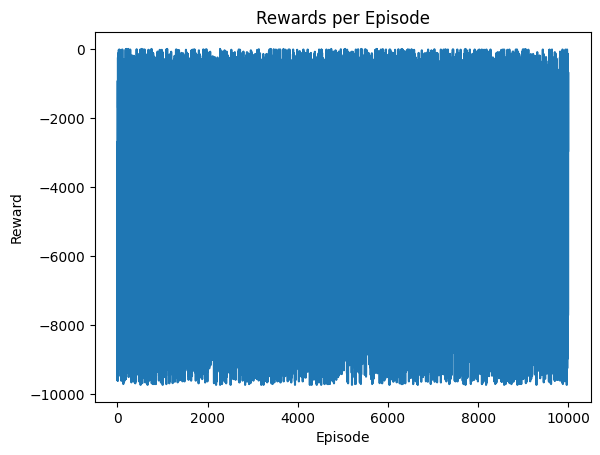

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have a list of rewards for each episode
#rewards_per_episode = [...]  # Populate this with your actual data

plt.plot(rewards_per_episode)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Rewards per Episode')
plt.show()


### Model tuning with Gridsearch

In [ ]:
# Tuning

def train_q_learning(alpha, gamma, epsilon, min_epsilon, decay_rate, n_episodes, n_states, n_actions, rewards):
    q_table = np.zeros((n_states, n_actions))
    rewards_per_episode = []

    for episode in range(n_episodes):
        current_state = np.random.randint(0, n_states)
        total_reward = 0

        while current_state < n_states - 1:
            if np.random.uniform(0, 1) < epsilon:
                action = np.random.randint(0, n_actions)
            else:
                action = np.argmax(q_table[current_state])

            next_state = current_state + 1  # Adjust based on environment logic
            reward = rewards[next_state]

            best_next_action = np.argmax(q_table[next_state])
            q_table[current_state, action] += alpha * (
                reward + gamma * q_table[next_state, best_next_action] - q_table[current_state, action]
            )

            total_reward += reward
            current_state = next_state

        rewards_per_episode.append(total_reward)
        epsilon = max(min_epsilon, epsilon * decay_rate)

    return q_table, rewards_per_episode


In [ ]:

def evaluate_q_learning_reward_weighted(q_table, n_states, train_data, rewards):
    correct_predictions = 0
    total_reward = 0
    reward_weighted_accuracy = []

    for state_index in range(n_states):
        predicted_action = np.argmax(q_table[state_index])  # Predicted action
        actual_action = train_data["action_num"].iloc[state_index]  # Actual action
        reward = rewards[state_index]  # Reward for the action

        if predicted_action == actual_action:
            correct_predictions += 1
            total_reward += reward

        accuracy = correct_predictions / (state_index + 1)
        reward_weighted_accuracy.append(total_reward / (state_index + 1))

        # Optional: Log progress
        if state_index % 100 == 0:
            print(f"Processed state {state_index}/{n_states} - Accuracy: {accuracy * 100:.2f}%, Reward-weighted Accuracy: {reward_weighted_accuracy[-1]}")

    final_reward_weighted_accuracy = total_reward / n_states
    return final_reward_weighted_accuracy * 100



In [ ]:
def evaluate_q_learning_prediction_efficiency(q_table, n_states, train_data, rewards):
    # Initialize cumulative rewards
    cumulative_predicted_reward = 0
    cumulative_actual_reward = 0

    # Iterate through states to calculate rewards
    for state_index in range(n_states - 1):
        # Predicted action from Q-table
        predicted_action = np.argmax(q_table[state_index])  # Best action for the current state
        # Actual action from the ground truth
        actual_action = train_data["action_num"].iloc[state_index]

        # Get reward for predicted action only if it matches the actual action
        if predicted_action == actual_action:
            predicted_reward = rewards[state_index + 1]  # Reward for the correct prediction
            cumulative_predicted_reward += predicted_reward

        # Get actual reward for the ground truth action
        actual_reward = rewards[state_index + 1]
        cumulative_actual_reward += actual_reward
    return cumulative_predicted_reward

In [ ]:
'''
def random_search_reward_weighted(n_iter, param_grid, n_states, n_actions, rewards, train_data):
    best_params = None
    best_reward_weighted_accuracy = float('-inf')

    for _ in tqdm(range(n_iter), desc="Searching for params ..."):
        alpha = random.choice(param_grid['alpha'])
        gamma = random.choice(param_grid['gamma'])
        epsilon = random.choice(param_grid['epsilon'])
        min_epsilon = random.choice(param_grid['decay_rate'])
        decay_rate = random.choice(param_grid['decay_rate'])
        n_episodes = random.choice(param_grid['n_episodes'])

        q_table, _ = train_q_learning(alpha, gamma, epsilon, min_epsilon, decay_rate, n_episodes, n_states, n_actions, rewards)
        reward_weighted_accuracy = evaluate_q_learning_reward_weighted(q_table, n_states, train_data, rewards)

        if reward_weighted_accuracy > best_reward_weighted_accuracy:
            best_reward_weighted_accuracy = reward_weighted_accuracy
            best_params = (alpha, gamma, epsilon, min_epsilon, decay_rate, n_episodes)

        print(f"Iteration Reward-weighted Accuracy: {reward_weighted_accuracy:.2f}%, Best Reward-weighted Accuracy: {best_reward_weighted_accuracy:.2f}%")

    return best_params, best_reward_weighted_accuracy

# Define the parameter grid
param_grid = {
    'alpha': [0.01, 0.05, 0.1, 0.2, 0.25, 0.3, 0.5, 0.7, 0.9, 1],
    'gamma': [0.75, 0.85, 0.9, 0.95, 0.99],
    'epsilon': [1.0, 0.5, 0.1, 0.05, 0.01],
    'min_epsilon': [0.05, 0.01, 0.005, 0.001, 0.001],
    'decay_rate': [0.95, 0.96, 0.97, 0.99, 0.995, 0.997, 0.999],
    'n_episodes': [1500, 4000,6000, 8000, 9000, 10000, 11000, 12000, 14000, 18000, 21000, 24000, 28000]
}

# Perform Random Search
best_params, best_reward_weighted_accuracy = random_search_reward_weighted(50, param_grid, n_states, n_actions, rewards, train_data)
print(f"Best Hyperparameters: {best_params}")
print(f"Best Reward-weighted Accuracy: {best_reward_weighted_accuracy:.2f}%")
'''


'\ndef random_search_reward_weighted(n_iter, param_grid, n_states, n_actions, rewards, train_data):\n    best_params = None\n    best_reward_weighted_accuracy = float(\'-inf\')\n\n    for _ in tqdm(range(n_iter), desc="Searching for params ..."):\n        alpha = random.choice(param_grid[\'alpha\'])\n        gamma = random.choice(param_grid[\'gamma\'])\n        epsilon = random.choice(param_grid[\'epsilon\'])\n        min_epsilon = random.choice(param_grid[\'decay_rate\'])\n        decay_rate = random.choice(param_grid[\'decay_rate\'])\n        n_episodes = random.choice(param_grid[\'n_episodes\'])\n\n        q_table, _ = train_q_learning(alpha, gamma, epsilon, min_epsilon, decay_rate, n_episodes, n_states, n_actions, rewards)\n        reward_weighted_accuracy = evaluate_q_learning_reward_weighted(q_table, n_states, train_data, rewards)\n\n        if reward_weighted_accuracy > best_reward_weighted_accuracy:\n            best_reward_weighted_accuracy = reward_weighted_accuracy\n        

In [ ]:
'''
train_data = newdf0
train_data['action_num'] = train_data[f"refined-action"].map(action_mapping)
def random_search_prediction_efficiency(n_iter, param_grid, n_states, n_actions, rewards, train_data):
    best_params = None
    best_cumulative_pred_reward = float('-inf')

    for _ in tqdm(range(n_iter), desc="Searching for params ..."):
        alpha = random.choice(param_grid['alpha'])
        gamma = random.choice(param_grid['gamma'])
        epsilon = random.choice(param_grid['epsilon'])
        min_epsilon = random.choice(param_grid['decay_rate'])
        decay_rate = random.choice(param_grid['decay_rate'])
        n_episodes = random.choice(param_grid['n_episodes'])

        q_table, _ = train_q_learning(alpha, gamma, epsilon, min_epsilon, decay_rate, n_episodes, n_states, n_actions, rewards)
        cumulative_pred_reward = evaluate_q_learning_prediction_efficiency(q_table, n_states, train_data, rewards)

        if cumulative_pred_reward > best_cumulative_pred_reward:
            best_cumulative_pred_reward = cumulative_pred_reward
            best_params = (alpha, gamma, epsilon, min_epsilon, decay_rate, n_episodes)

        print(f"Iteration cumulative predicted reward: {cumulative_pred_reward:.2f}%, Best cumulative predicted reward: {best_cumulative_pred_reward:.2f}%")

    return best_params, best_cumulative_pred_reward

# Define the parameter grid
param_grid = {
    'alpha': [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.25, 0.3, 0.5, 0.7, 0.9, 1],
    'gamma': [0.75, 0.85, 0.9, 0.95, 0.99],
    'epsilon': [1.0, 0.5, 0.1, 0.05, 0.01, 0.005],
    'min_epsilon': [0.05, 0.01, 0.005, 0.001, 0.001],
    'decay_rate': [0.95, 0.99, 0.995, 0.997, 0.999],
    'n_episodes': [1500, 4000,6000, 8000, 9000, 10000, 11000, 12000, 14000, 16000, 18000, 20000, 22000, 24000, 26000, 28000, 30000]
}

# Perform Random Search
best_params, best_cumulative_pred_reward = random_search_prediction_efficiency(50, param_grid, n_states, n_actions, rewards, train_data)
print(f"Best Hyperparameters: {best_params}")
print(f"Best cumulative predicted reward: {best_cumulative_pred_reward:.2f}%")
'''

'\ntrain_data = newdf0\ntrain_data[\'action_num\'] = train_data[f"refined-action"].map(action_mapping)\ndef random_search_prediction_efficiency(n_iter, param_grid, n_states, n_actions, rewards, train_data):\n    best_params = None\n    best_cumulative_pred_reward = float(\'-inf\')\n\n    for _ in tqdm(range(n_iter), desc="Searching for params ..."):\n        alpha = random.choice(param_grid[\'alpha\'])\n        gamma = random.choice(param_grid[\'gamma\'])\n        epsilon = random.choice(param_grid[\'epsilon\'])\n        min_epsilon = random.choice(param_grid[\'decay_rate\'])\n        decay_rate = random.choice(param_grid[\'decay_rate\'])\n        n_episodes = random.choice(param_grid[\'n_episodes\'])\n\n        q_table, _ = train_q_learning(alpha, gamma, epsilon, min_epsilon, decay_rate, n_episodes, n_states, n_actions, rewards)\n        cumulative_pred_reward = evaluate_q_learning_prediction_efficiency(q_table, n_states, train_data, rewards)\n\n        if cumulative_pred_reward > bes